In [82]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
try:
  import google.colab
except ImportError:
  from dolfin import *
else:
  try:
    from dolfin import *
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
%matplotlib inline

In [83]:
# 1. Read the mesh for this problem

!wget "https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip" -O "/tmp/github_files.zip"

zip_ref = zipfile.ZipFile("/tmp/github_files.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

mesh = Mesh("/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh.xml")
subdomains = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh_facet_region.xml")


--2022-08-03 14:38:41--  https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main [following]
--2022-08-03 14:38:41--  https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/github_files.zip’

/tmp/github_files.z     [  <=>               ]   1.86M  6.92MB/s    in 0.3s    

2022-08-03 14:38:42 (6.92 MB/s) - ‘/tmp/github_files.zip’ saved [1947612]



In [84]:
# 2A. Create Finite Element space (Lagrange P1)
VT = FunctionSpace(mesh,"CG",1)
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
ds_sym = ds(2) + ds(3) + ds(6)
ds_bottom = ds(1)
ds_sf = ds(5) + ds(7) + ds(8) + ds(9) + ds(10)
ds_top = ds(4) + ds(11) + ds(12) + ds(13) + ds(14)
ds_out = ds(15)
dx_cc1 = dx(1) 
dx_cc2 = dx(2)
dx_cc2_upper = dx(4)
dx_bb_surround = dx(3)
dx_cc = dx(6)
dx_cb = dx(5)
dx_ss = dx(7)
T_, psi = TrialFunction(VT), TestFunction(VT)
T = Function(VT)

346.293922241477
0.7657019931398242
452.25678572608933
452.25678572601095


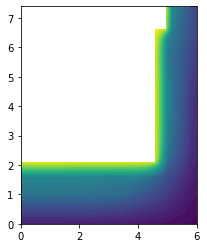

In [85]:
# Time scale
t_max = 2.
num_steps = 100
dt = t_max/num_steps

# Boundary and Source terms
Q = Expression("0*t", degree=2, t=0.) #Source term
Q_previous = interpolate(Q,VT)
T_left = Expression("300.+600.*t", degree=2, t=0.)
T_right = T_bottom = Constant(300.)

#Thermal conductivityies
k_cc1 = 15.5
k_cc2 = k_cc2_upper = 39.5
k_bb_surround = 20.2
k_cb = 5.5
k_ss = 48.
k_cc = 6. #as_tensor([[7.,0],[0,5.]])

#Material densities
rho_cc1 = 3520.0e-2
rho_cc2 = rho_cc2_upper = 3200.0e-2
rho_bb_surround = 2800.0e-2
rho_cb = 1760.0e-2
rho_ss = 7900.0e-2
rho_cc = 2080.0e-2

#Heat capacities
c_cc1 = 744.2e-2
c_cc2 = c_cc2_upper = 683.4e-2 
c_bb_surround = 705.9e-2
c_cb = 342.7e-2
c_ss = 466.0e-2
c_cc = 342.7e-2

#Convection coefficients
h_sf = 100.
h_out = h_bottom = 50.

#Boundary value
#bcs = [DirichletBC(VT,T_left,boundaries,5),DirichletBC(VT,T_left,boundaries,7),DirichletBC(VT,T_left,boundaries,8),DirichletBC(VT,T_left,boundaries,9),DirichletBC(VT,T_left,boundaries,10),\
#       DirichletBC(VT,T_right,boundaries,15),DirichletBC(VT,T_right,boundaries,1)]

#Intial value
T_previous = interpolate(Constant(300.),VT)
x0 = Expression("x[0]",element=VT.ufl_element())
x1 = Expression("x[1]",element=VT.ufl_element())

#Backward difference in time
F_T = \
rho_cc1 * c_cc1 * inner(psi,T_) * dx_cc1 + rho_cc2 * c_cc2 * inner(psi,T_) * dx_cc2 + rho_bb_surround * c_bb_surround * inner(psi,T_) * dx_bb_surround + \
rho_cc2_upper * c_cc2_upper * inner(psi,T_) * dx_cc2_upper + rho_cb * c_cb * inner(psi,T_) * dx_cb + rho_ss * c_ss * inner(psi,T_) * dx_ss + rho_cc * c_cc * inner(psi,T_) * dx_cc - \
rho_cc1 * c_cc1 * inner(psi,T_previous) * dx_cc1 - rho_cc2 * c_cc2 * inner(psi,T_previous) * dx_cc2 - rho_bb_surround * c_bb_surround * inner(psi,T_previous) * dx_bb_surround - \
rho_cc2_upper * c_cc2_upper * inner(psi,T_previous) * dx_cc2_upper - rho_cb * c_cb * inner(psi,T_previous) * dx_cb - rho_ss * c_ss * inner(psi,T_previous) * dx_ss - \
rho_cc * c_cc * inner(psi,T_previous) * dx_cc + k_cc1 * inner(grad(T_),grad(psi)) * dx_cc1 + k_cc2 * inner(grad(T_),grad(psi)) * dx_cc2 + \
k_bb_surround * inner(grad(T_),grad(psi)) * dx_bb_surround + k_cc2_upper * inner(grad(T_),grad(psi)) * dx_cc2_upper + k_cb * inner(grad(T_),grad(psi)) * dx_cb + \
k_ss * inner(grad(T_),grad(psi)) * dx_ss + k_cc * inner(grad(T_),grad(psi)) * dx_cc + \
h_sf * inner(psi,T_) * ds_sf + h_bottom * inner(psi,T_) * ds_bottom + h_out * inner(psi,T_) * ds_out - \
h_sf * inner(psi,T_left) * ds_sf - h_bottom * inner(psi,T_bottom) * ds_bottom - h_out * inner(psi,T_right) * ds_out - \
inner(psi,Q) * dx

a_T = lhs(F_T)
l_T = rhs(F_T)

eigvals, _ = np.linalg.eig(assemble(a_T).array())

#Solution of system of equations
t = 0.
xdmf_file = XDMFFile("/tmp/transient_heat_conduction_LSTM_PINN-main/solution_field/thermal_results.xdmf") #Path to save output files in google drive
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False
xdmf_file.write(T_previous,0)

for i in range(num_steps):
	 t += dt
	 T_left.t = t
	 T_right.t = t
	 Q.t = t
	 solve(a_T == l_T, T)
	 xdmf_file.write(T,t)
	 T_previous.assign(T) 

plot(T)

print(max(abs(eigvals)))
print(min(eigvals))
print(max(abs(eigvals))/min(abs(eigvals)))
print(np.linalg.cond(assemble(a_T).array()))